# Python for Water Resources Engineering
[Jon Herman, University of California, Davis](http://faculty.engineering.ucdavis.edu/herman/)

### NumPy and Matplotlib

NumPy is a package used for matrix operations, and Matplotlib provides Matlab-like plotting capabilities. These packages are extremely common, and anyone using Python for research will be familiar with them. They are included in your Anaconda distribution. Let's import NumPy and create a vector and a matrix:

In [7]:
import numpy as np
v = np.array([1,2,3])
M = np.array([[1, 2, 3], [4, 5, 6]])
print(v[1])
print(M[1,2])

2
6


It's standard to import packages as a shortened prefix to access their functions (as opposed to `from numpy import *`) because some packages may have conflicting function names. With the prefix `np`, we know the functions are from NumPy.

Use the `zeros` and `ones` functions to create arrays of size `(n,m)`:

In [11]:
A = 3*np.ones((4,3))
B = np.zeros((4,3))

#### Matrix operations 
The array/matrix types provided by NumPy can use standard arithmetic operators to perform elementwise addition, multiplication, etc. It is *very important* to use these functions instead of looping over the indices yourself! See the speed difference when we try to add some large matrices of random numbers:

In [22]:
A = np.random.rand(10000,1000)
B = np.random.rand(10000,1000)

In [23]:
%%timeit
C = A + B

10 loops, best of 3: 28.4 ms per loop


In [24]:
%%timeit
C = np.zeros((10000,1000))
for i in range(10000):
    for j in range(1000):
        C[i,j] = A[i,j] + B[i,j]

1 loops, best of 3: 2.99 s per loop


The `%%timeit` command is only available in the IPython notebook, so if you're running this from Spyder don't worry about it. The point is: there is about 100x speedup from using the built-in NumPy matrix arithmetic instead of Python loops! Keep this in mind, especially when you're working with larger matrices. Some more arithmetic:

In [29]:
C = A*B # elementwise multiplication, different from Matlab
D = np.dot(A.T,B) # matrix multiplication (.T is transpose)

The same lesson goes for other matrix operations like finding the mean, min, max, or sum across rows or columns. NumPy provides all of these functions, either in the format `A.mean()` or `np.mean(A)`, which are equivalent. If the `axis` keyword is not specified, the operation will be performed over all dimensions of the matrix.

In [30]:
%%timeit
c = A.sum(axis=0) # axis=0: sum over rows, axis=1: sum over columns

100 loops, best of 3: 4.94 ms per loop


In [31]:
%%timeit
c = np.zeros(A.shape[1])
for j in range(len(c)):
    for i in range(A.shape[0]):
        c[j] += A[i,j] 

1 loops, best of 3: 2.45 s per loop


Here we see almost a 1000x speedup! Keep in mind when it comes to matrix operations, loops are bad, and the NumPy built-in (vectorized) functions are good.

#### Loading Data from Files and Plotting
Normally you will not be typing out matrices by hand. It's much more common to load matrices from files, for example plain text files where the values are separated by spaces, commas (.csv) or tabs (.tsv). The separating character is called the delimiter. Here's an example of loading the monthly time series of [full natural flows into Folsom Reservoir](./data/folsom-FNF.txt):

In [33]:
Q = np.loadtxt('data/folsom-FNF.txt', delimiter=' ', skiprows=1)

There is an equivalent `np.savetxt(filename, Q, ...)` to save a matrix/vector to a file. In `np.loadtxt`, the `skiprows` parameter just allows a header line with non-numerical values to be ignored. Now that we have the Q matrix loaded into memory, let's plot the time series of April inflows:

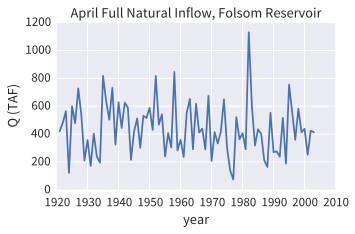

In [34]:
# Setup, you only need the third line here to import "plt"
%matplotlib inline
from ipy_setup import setup
import matplotlib.pyplot as plt
setup(plt)

years = Q[:,0] # first column
april = Q[:,7]
plt.plot(years, april) # plt.bar(years, april) for a bar plot
plt.xlabel('year')
plt.ylabel('Q (TAF)')
plt.title('April Full Natural Inflow, Folsom Reservoir')
plt.show()

Easy! If you want to save a figure, use `plt.savefig('april-fnf.svg')`. The filetype will be recognized by the extension. You can also save as raster types like PNG. There are many, many plot types supported by Matplotlib (and the flexibility to invent new ones yourself!) [This Github repository](https://github.com/VictoriaLynn/plotting-examples) contains a few nice examples, including Matlab/R versions.

Let's plot the minimum, mean, and maximum inflow by month. Remember the list/array slicing syntax from [the last tutorial](language-basics.html)? It's the same thing in NumPy: `start:stop:step`. The only difference is now there are multiple dimensions.

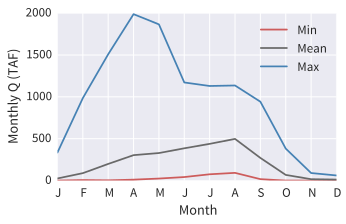

In [47]:
# exclude the first column (years) and the last (total)
# and use axis=0 (operate over the rows, not columns)
# important: indices 1:13 does not include 13
mins = Q[:,1:13].min(axis=0) 
maxes = Q[:,1:13].max(axis=0)
means = Q[:,1:13].mean(axis=0)
plt.plot(range(12), mins, color='indianred')
plt.plot(range(12), means, color='dimgray')
plt.plot(range(12), maxes, color='steelblue')
plt.ylabel('Monthly Q (TAF)')
plt.xlabel('Month')
plt.xlim([0,11])
plt.legend(['Min', 'Mean', 'Max'])
plt.xticks(range(12), ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
plt.show()

You may be interested in the list of [all named colors available in Matplotlib](http://matplotlib.org/examples/color/named_colors.html). There are quite a few.

While we're at it, let's make an exceedance curve for the total annual inflow. To do this, we have to sort the data in reverse order and plot against $i/N$ (or another plotting position). To make things more interesting, we'll divide the data into the periods 1921-1959 (38 years) and 1960-2003 (44 years). The total flow is included in the last column of the matrix already, but it gives us an excuse to use `np.sum`:

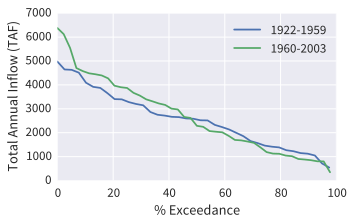

In [46]:
Qhist = Q[:39,1:13].sum(axis=1) # summing over columns here
Qmodern = Q[39:,1:13].sum(axis=1)
Nh = len(Qhist) # number of data points
Nm = len(Qmodern)
# here's one place types matter: must divide by float not int
plt.plot(np.arange(Nh)/float(Nh)*100, np.sort(Qhist)[::-1]) 
plt.plot(np.arange(Nm)/float(Nm)*100, np.sort(Qmodern)[::-1]) 
plt.xlabel('% Exceedance')
plt.ylabel('Total Annual Inflow (TAF)')
plt.legend(['1922-1959', '1960-2003'])
plt.show()

One last plot before we move on -- let's make a scatter plot to see if winter (Jan-Mar) and spring (Apr-Jun) inflows are correlated.

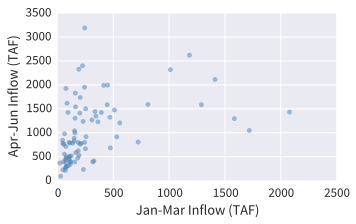

In [54]:
Qw = Q[:,1:4].sum(axis=1)
Qs = Q[:,4:7].sum(axis=1)
# arguments: s=size, alpha=transparency
plt.scatter(Qw,Qs, s=20, color='steelblue', alpha=0.5)
plt.xlabel('Jan-Mar Inflow (TAF)')
plt.ylabel('Apr-Jun Inflow (TAF)')
plt.xlim([0,2500])
plt.ylim([0,3500])
plt.show()

With an understanding of matrices and reading data from files, we'll take a detour into [Part 3: Optimization Methods](optimization.html). 